In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import os
import math
import random 

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/LGaimers2/input/train.csv')
test = pd.read_csv('/content/drive/MyDrive/LGaimers2/input/test.csv')

In [ ]:
train_df

,PRODUCT_ID,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,TRAIN_0000,1,0.531957,T100304,T_31,2.0,95.0,0.0,45.0,10.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,TRAIN_0001,1,0.531105,T100306,T_31,2.0,96.0,0.0,45.0,10.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,TRAIN_0002,1,0.532292,T100306,T_31,2.0,95.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TRAIN_0003,1,0.528141,T100306,T_31,2.0,87.0,0.0,45.0,10.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,TRAIN_0004,1,0.532289,T100306,T_31,2.0,95.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,TRAIN_1127,0,0.516681,T050304,A_31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1128,TRAIN_1128,1,0.530413,T100304,T_31,2.0,102.0,0.0,45.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1129,TRAIN_1129,1,0.533311,T100306,T_31,1.0,88.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1130,TRAIN_1130,0,0.513135,T010306,A_31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Y_Quality'>

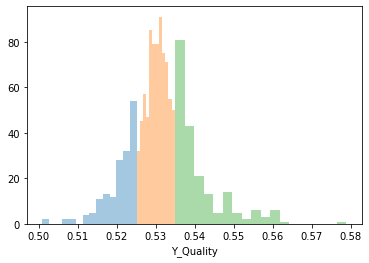

In [ ]:
# 초기 Y-Quality 분포 확인
below_standard_df = train_df[train_df['Y_Class']==0]
normal_standard_df = train_df[train_df['Y_Class']==1]
over_standard_df = train_df[train_df['Y_Class']==2]

sns.distplot(below_standard_df['Y_Quality'], kde=False)
sns.distplot(normal_standard_df['Y_Quality'], kde=False)
sns.distplot(over_standard_df['Y_Quality'], kde=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import warnings
warnings.filterwarnings(action='ignore')
from catboost import *
import sklearn
import math
from sklearn.preprocessing import LabelEncoder
import math


def log(train,test):
    col_list = train.columns
    for col in col_list :
        if '제곱' in col:
            train[col+'log'] = np.log1p(train[col])
            test[col+'log'] = np.log1p(test[col])
    return train,test

def del_columns(train, test):
    col_list = train.columns
    nan_list = []
    nan_cnt = []
    nan_col = []
    full_list = []
    for col in col_list:
        if train[col].isnull().sum() == 0 :
            full_list.append(col)
            continue
        nan_list.append([col, train[col].isnull().sum()])
        nan_cnt.append(train[col].isnull().sum())
        nan_col.append(col)

    PRODUCT_CODE = train['PRODUCT_CODE'].unique()

    '''모든값이 결측값이면 제거'''
    del_col = []
    for col in nan_list :
        if col[1] == len(train) :
            del_col.append(col[0])
    train = train.drop(columns=del_col)
    test = test.drop(columns=del_col)

    print(PRODUCT_CODE,'모든 값이 결측값인 columns : ', del_col)
    all_nan = len(del_col)

    '''값이 1개 존재하면 제거'''
    del_col = []
    col_list = train.describe().columns
    for col in col_list :
        if col == 'Y_Class':
            continue
        if col == 'Y_Quality':
            continue
        if col == 'LINE':
            continue
        if col == 'PRODUCT_CODE':
            continue
        if train[col].nunique()==1 :
            del_col.append(col)
    train = train.drop(columns=del_col)
    test = test.drop(columns=del_col)
    all_one = len(del_col)

    print(PRODUCT_CODE,'단일 값이 존재하는 columns : ', del_col)
    
    return train,test,all_nan,all_one
   
def make_train_test_dataset(train,test):
    train_x = train.drop(columns=['PRODUCT_ID','PRODUCT_CODE','Y_Class','Y_Quality'])
    test_x = test.drop(columns=['PRODUCT_ID','PRODUCT_CODE'])
    train_y = train['Y_Quality']
    train_w = train[['Y_Class']]
    return train_x, test_x, train_y, train_w

def fillna(train,test,value):
    train = train.fillna(value)
    test = test.fillna(value)
    return train,test

def labelencoder(train,test,col_list):
    qual_col = col_list
    for i in qual_col:
        le = LabelEncoder()
        le = le.fit(train[i])
        train[i] = le.transform(train[i])

        for label in np.unique(test[i]): 
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        test[i] = le.transform(test[i]) 
    return train,test

def multi_col(train,test) : 
    col_list = train.columns
    for col in col_list :
        if col == 'LINE':
            continue
        train[col+'제곱'] = (train[col]**2)//100
        test[col+'제곱'] = (test[col]**2)//100
    return train,test

def cnt_plot(data, col,  hue, title):
    plt.rc('font', family='Malgun Gothic')
    plt.rc("axes",unicode_minus=False)
    plt.figure(figsize=(10,5))
    plt.xticks(rotation=40)
    ax=sns.countplot(x=col, hue=hue ,data = data, palette='Greens')
    for p in ax.patches:
        ax.annotate("%.0f"%p.get_height(),(p.get_x() + p.get_width()/2, p.get_height()),
                   ha='center', va='center', fontsize=14, color='black', xytext=(0,10),
                   textcoords='offset points')
    plt.title(title)
    plt.show()

In [ ]:
def above_nan(dataframe):
    del_col = []
    for col in dataframe.columns:
        counts = len(dataframe.loc[dataframe[col] == -1])

        if counts >= int(dataframe.shape[0] / 2):
            del_col.append(col)

    dataframe = dataframe.drop(columns=del_col)
    return dataframe

In [ ]:
train_df

,PRODUCT_ID,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,TRAIN_0000,1,0.531957,T100304,T_31,2.0,95.0,0.0,45.0,10.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,TRAIN_0001,1,0.531105,T100306,T_31,2.0,96.0,0.0,45.0,10.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,TRAIN_0002,1,0.532292,T100306,T_31,2.0,95.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TRAIN_0003,1,0.528141,T100306,T_31,2.0,87.0,0.0,45.0,10.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,TRAIN_0004,1,0.532289,T100306,T_31,2.0,95.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,TRAIN_1127,0,0.516681,T050304,A_31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1128,TRAIN_1128,1,0.530413,T100304,T_31,2.0,102.0,0.0,45.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1129,TRAIN_1129,1,0.533311,T100306,T_31,1.0,88.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1130,TRAIN_1130,0,0.513135,T010306,A_31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
trainA_31 = train_df[train_df['PRODUCT_CODE']=='A_31']
train_T_31 = train_df[train_df['PRODUCT_CODE']=='T_31']
train_O_31 = train_df[train_df['PRODUCT_CODE']=='O_31']

testA_31 = test[test['PRODUCT_CODE']=='A_31']
test_T_31 = test[test['PRODUCT_CODE']=='T_31']
test_O_31 = test[test['PRODUCT_CODE']=='O_31']

In [ ]:
trainA_31, testA_31, A_all_nan, A_all_one = del_columns(trainA_31,testA_31)
train_T_31, test_T_31, T_all_nan, T_all_one = del_columns(train_T_31,test_T_31)
train_O_31, test_O_31, O_all_nan, O_all_one = del_columns(train_O_31,test_O_31)

['A_31'] 모든 값이 결측값인 columns :  ['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15', 'X_16', 'X_17', 'X_18', 'X_19', 'X_20', 'X_21', 'X_22', 'X_23', 'X_24', 'X_25', 'X_26', 'X_27', 'X_28', 'X_29', 'X_30', 'X_31', 'X_32', 'X_33', 'X_34', 'X_35', 'X_36', 'X_37', 'X_38', 'X_39', 'X_40', 'X_41', 'X_42', 'X_43', 'X_44', 'X_45', 'X_46', 'X_47', 'X_48', 'X_49', 'X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56', 'X_57', 'X_58', 'X_59', 'X_60', 'X_61', 'X_62', 'X_63', 'X_64', 'X_65', 'X_66', 'X_67', 'X_68', 'X_69', 'X_70', 'X_71', 'X_72', 'X_73', 'X_74', 'X_75', 'X_76', 'X_77', 'X_78', 'X_79', 'X_80', 'X_81', 'X_82', 'X_83', 'X_84', 'X_85', 'X_86', 'X_87', 'X_88', 'X_89', 'X_90', 'X_91', 'X_92', 'X_93', 'X_94', 'X_95', 'X_96', 'X_97', 'X_98', 'X_99', 'X_100', 'X_101', 'X_102', 'X_103', 'X_104', 'X_105', 'X_106', 'X_107', 'X_108', 'X_109', 'X_110', 'X_111', 'X_112', 'X_113', 'X_114', 'X_115', 'X_116', 'X_117', 'X_118', 'X_119', 'X_12

In [ ]:
trainA_31_x,testA_31_x, trainA_31_y, trainA_31_w = make_train_test_dataset(trainA_31,testA_31)
train_T_31_x,test_T_31_x, train_T_31_y, train_T_31_w = make_train_test_dataset(train_T_31,test_T_31)
train_O_31_x,test_O_31_x, train_O_31_y, train_O_31_w = make_train_test_dataset(train_O_31,test_O_31)

trainA_31_x,testA_31_x = labelencoder(trainA_31_x,testA_31_x,['LINE'])
train_T_31_x,test_T_31_x = labelencoder(train_T_31_x,test_T_31_x,['LINE'])
train_O_31_x,test_O_31_x = labelencoder(train_O_31_x,test_O_31_x,['LINE'])

trainA_31_x,testA_31_x = fillna(trainA_31_x,testA_31_x,-1)
train_T_31_x,test_T_31_x = fillna(train_T_31_x,test_T_31_x,-1)
train_O_31_x,test_O_31_x = fillna(train_O_31_x,test_O_31_x,-1)

print(trainA_31_x.shape,testA_31_x.shape,train_T_31_x.shape,test_T_31_x.shape)

(294, 1876) (46, 1876) (830, 915) (487, 915)


In [ ]:
trainA_31_x

,LINE,X_128,X_129,X_130,X_131,X_132,X_133,X_134,X_136,X_137,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
17,0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0
18,3,-1.0,-1.0,20153.0,24984.0,0.21,0.22,0.21,821.0,820.0,...,53.55,52.68,49.97,56.66,63.52,1.0,210.5,214.6,201.6,191.9
21,2,18031.0,18031.0,-1.0,-1.0,0.19,0.20,0.19,354.0,354.0,...,57.74,52.51,54.45,57.99,63.16,1.0,-1.0,-1.0,-1.0,-1.0
22,2,8164.0,8164.0,-1.0,-1.0,0.19,0.20,0.19,172.0,172.0,...,56.38,57.10,51.49,56.08,64.40,1.0,-1.0,-1.0,-1.0,-1.0
27,3,-1.0,-1.0,17014.0,21844.0,0.20,0.22,0.20,741.0,740.0,...,50.45,50.29,57.54,52.59,62.37,0.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,1,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0
1120,1,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0
1121,1,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0
1127,2,10729.0,10729.0,-1.0,-1.0,0.20,0.21,0.19,293.0,293.0,...,51.30,47.66,60.00,53.75,62.58,1.0,-1.0,-1.0,-1.0,-1.0


In [ ]:
train_T_31_x

,LINE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,X_11,X_12,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,0,2.0,95.0,45.0,10.0,45.0,10.0,31.0,483.4,489.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,2.0,96.0,45.0,10.0,53.0,10.0,52.0,519.3,526.5,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,2.0,95.0,45.0,10.0,60.0,10.0,52.0,502.5,510.1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000,-1.000000
3,1,2.0,87.0,45.0,10.0,53.0,10.0,52.0,478.9,483.4,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,2.0,95.0,45.0,10.0,51.0,10.0,52.0,508.4,516.3,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,1,2.0,87.0,45.0,10.0,51.0,10.0,52.0,493.5,500.9,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000,-1.000000
1126,0,2.0,93.0,45.0,11.0,45.0,10.0,31.0,514.1,519.7,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000,-1.000000
1128,0,2.0,102.0,45.0,11.0,45.0,10.0,31.0,519.6,526.5,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000,-1.000000
1129,1,1.0,88.0,45.0,10.0,51.0,10.0,52.0,465.3,469.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000,-1.000000


In [ ]:
train_O_31_x

,LINE,X_1,X_2,X_5,X_7,X_8,X_9,X_11,X_12,X_13,...,X_924,X_925,X_926,X_927,X_928,X_929,X_930,X_931,X_932,X_933
92,0,40.0,94.0,11.0,45.0,10.0,31.0,505.8,510.9,497.1,...,189.2,179.5,173.190323,168.6,321.0,303.036364,289.0,13.6,13.406667,13.2
232,0,4.0,100.0,11.0,45.0,10.0,31.0,500.4,504.8,492.4,...,175.4,165.7,159.864516,148.7,326.0,311.763636,298.0,13.7,13.425806,13.2
368,1,21.0,87.0,10.0,61.0,10.0,52.0,470.6,474.9,462.9,...,188.2,172.9,167.087097,161.1,326.0,304.818182,289.0,13.6,13.380000,13.2
375,0,154.0,97.0,11.0,45.0,10.0,31.0,513.2,517.7,504.8,...,184.0,181.6,171.522581,163.3,326.0,305.890909,289.0,13.6,13.396667,13.2
605,1,146.0,94.0,10.0,67.0,11.0,52.0,499.8,507.7,486.3,...,177.0,178.7,168.043333,161.9,327.0,309.745454,291.0,13.6,13.350000,13.2
736,0,4.0,98.0,11.0,45.0,10.0,31.0,500.0,505.3,493.2,...,181.7,160.0,155.541935,149.8,327.0,312.018182,298.0,13.6,13.458065,13.3
898,1,6.0,89.0,10.0,51.0,10.0,52.0,465.9,471.4,457.3,...,166.1,166.0,161.046667,151.3,326.0,312.537037,298.0,13.7,13.440000,13.2
1035,1,6.0,90.0,10.0,51.0,10.0,52.0,466.1,471.4,457.0,...,176.0,161.9,157.464516,154.5,327.0,312.454545,298.0,13.7,13.454839,13.3


In [ ]:
import scipy.stats as stats

# 자기 자신 포함 corr 높은 변수명 저장
def correlation(dataframe, standard):
    doubt = []
    for i in dataframe.columns:
        corr , p_val = stats.pearsonr(dataframe[standard], dataframe[i])
        if abs(corr) >= 1 and p_val < 0.05:
            print('standard : ', standard ,'    ', 'i : ', i, ' ', stats.pearsonr(dataframe[standard], dataframe[i]))
            if i[-4:] != 'corr':
                doubt.append(i)
    return doubt

In [ ]:
from sklearn.preprocessing import StandardScaler  # 표준화 패키지 라이브러리 
from sklearn.decomposition import PCA

# 자기 자신 포함 corr 높은 변수들 하나의 변수로 pca
def make_pca_dataset(train_df, test_df, standard):
    doubt = correlation(train_df, standard)

    doubt_df = train_df[doubt]
    tmp_test_df = test_df[doubt]
    print(doubt)

    standard_doubt = StandardScaler().fit_transform(doubt_df) # x객체에 x를 표준화한 데이터를 저장
    standard_test = StandardScaler().fit_transform(tmp_test_df) # x객체에 x를 표준화한 데이터를 저장

    pca = PCA(n_components=1) # 주성분을 몇개로 할지 결정
    printcipalComponents = pca.fit_transform(standard_doubt)
    printcipalComponents_test = pca.fit_transform(standard_test)

    train_df = train_df.drop(columns=doubt_df.columns)
    test_df = test_df.drop(columns=doubt_df.columns)

    train_df[standard +' corr'] = printcipalComponents
    test_df[standard +' corr'] = printcipalComponents_test

    return train_df, test_df

In [ ]:
line_A = trainA_31_x['LINE']
line_T = train_T_31_x['LINE']
line_O = train_O_31_x['LINE']

except_line_A = trainA_31_x.drop(columns='LINE')
except_line_T = train_T_31_x.drop(columns='LINE')
except_line_O = train_O_31_x.drop(columns='LINE')

In [ ]:
tmp = except_line_A.copy()
tmp_test = testA_31_x.copy()

In [ ]:
tmp_test

,LINE,X_128,X_129,X_130,X_131,X_132,X_133,X_134,X_136,X_137,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
24,3,-1.0,-1.0,19061.0,23892.0,0.21,0.22,0.21,800.0,799.0,...,52.50,59.20,54.16,56.59,62.31,1.0,268.0,264.4,261.7,239.7
25,3,-1.0,-1.0,16292.0,21123.0,0.21,0.22,0.21,733.0,732.0,...,50.90,41.63,51.09,55.65,62.68,1.0,-1.0,-1.0,-1.0,-1.0
70,3,-1.0,-1.0,7786.0,12616.0,0.21,0.22,0.21,426.0,425.0,...,52.34,47.25,60.31,54.83,62.58,1.0,-1.0,-1.0,-1.0,-1.0
78,2,18514.0,18514.0,-1.0,-1.0,0.20,0.21,0.20,446.0,446.0,...,51.37,55.70,52.49,48.34,62.12,1.0,-1.0,-1.0,-1.0,-1.0
117,2,10712.0,10712.0,-1.0,-1.0,0.20,0.21,0.20,293.0,293.0,...,49.67,45.00,49.81,55.19,67.17,1.0,-1.0,-1.0,-1.0,-1.0
121,3,-1.0,-1.0,5687.0,5687.0,0.19,0.20,0.19,220.0,220.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,1.0,-1.0,-1.0,-1.0,-1.0
128,1,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0
134,0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0
149,3,-1.0,-1.0,20183.0,25014.0,0.21,0.22,0.21,821.0,820.0,...,53.94,57.38,42.37,51.67,65.05,1.0,247.1,253.9,262.6,236.5
162,0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0


In [ ]:
for i in except_line_A:
    try:
        tmp, tmp_test = make_pca_dataset(tmp, tmp_test, i)
    except:
        continue   
tmp

Index([], dtype='object')
standard :  X_129      i :  X_129   PearsonRResult(statistic=1.0, pvalue=0.0)
Index(['X_129'], dtype='object')
Index([], dtype='object')
standard :  X_131      i :  X_131   PearsonRResult(statistic=1.0, pvalue=0.0)
Index(['X_131'], dtype='object')
Index([], dtype='object')
standard :  X_133      i :  X_133   PearsonRResult(statistic=1.0, pvalue=0.0)
Index(['X_133'], dtype='object')
Index([], dtype='object')
standard :  X_136      i :  X_136   PearsonRResult(statistic=1.0, pvalue=0.0)
Index(['X_136'], dtype='object')
standard :  X_137      i :  X_137   PearsonRResult(statistic=1.0, pvalue=0.0)
Index(['X_137'], dtype='object')
standard :  X_138      i :  X_138   PearsonRResult(statistic=1.0, pvalue=0.0)
Index(['X_138'], dtype='object')
standard :  X_139      i :  X_139   PearsonRResult(statistic=1.0, pvalue=0.0)
Index(['X_139'], dtype='object')
standard :  X_140      i :  X_140   PearsonRResult(statistic=1.0, pvalue=0.0)
Index(['X_140'], dtype='object')
standard

,X_128,X_130,X_132,X_134,X_149,X_150,X_152,X_157,X_159,X_161,...,X_2801 corr,X_2837 corr,X_2839 corr,X_2841 corr,X_2842 corr,X_2843 corr,X_2871 corr,X_2872 corr,X_2873 corr,X_2874 corr
17,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
18,-1.0,20153.0,0.21,0.21,422.0,411.0,180.0,214.8,215.0,214.9,...,1.083886,0.802164,0.994544,0.978088,-0.967676,-0.966531,1.121251,7.592093,7.418036,7.401381
21,18031.0,-1.0,0.19,0.19,430.0,418.0,180.0,214.9,215.0,215.0,...,0.914520,1.135299,0.991192,1.000599,-0.965289,-0.966538,1.121251,-0.116507,-0.116767,-0.115355
22,8164.0,-1.0,0.19,0.19,437.0,429.0,180.0,214.9,214.9,214.9,...,0.914520,1.238464,0.987840,0.952640,-0.965217,-0.966538,1.121251,-0.116507,-0.116767,-0.115355
27,-1.0,17014.0,0.20,0.20,425.0,414.0,180.0,214.9,214.9,214.9,...,1.253252,-0.807632,-1.026765,0.583642,-0.968056,-0.966527,0.113154,-0.116507,-0.116767,-0.115355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
1120,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
1121,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
1127,10729.0,-1.0,0.20,0.19,436.0,427.0,180.0,214.9,214.9,214.9,...,0.914520,0.913925,0.987840,1.003046,-0.965331,-0.966540,1.121251,-0.116507,-0.116767,-0.115355


In [ ]:
tmp.insert(0, 'LINE', line_A.values )
tmp

,LINE,X_128,X_130,X_132,X_134,X_149,X_150,X_152,X_157,X_159,...,X_2801 corr,X_2837 corr,X_2839 corr,X_2841 corr,X_2842 corr,X_2843 corr,X_2871 corr,X_2872 corr,X_2873 corr,X_2874 corr
17,0,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
18,3,-1.0,20153.0,0.21,0.21,422.0,411.0,180.0,214.8,215.0,...,1.083886,0.802164,0.994544,0.978088,-0.967676,-0.966531,1.121251,7.592093,7.418036,7.401381
21,2,18031.0,-1.0,0.19,0.19,430.0,418.0,180.0,214.9,215.0,...,0.914520,1.135299,0.991192,1.000599,-0.965289,-0.966538,1.121251,-0.116507,-0.116767,-0.115355
22,2,8164.0,-1.0,0.19,0.19,437.0,429.0,180.0,214.9,214.9,...,0.914520,1.238464,0.987840,0.952640,-0.965217,-0.966538,1.121251,-0.116507,-0.116767,-0.115355
27,3,-1.0,17014.0,0.20,0.20,425.0,414.0,180.0,214.9,214.9,...,1.253252,-0.807632,-1.026765,0.583642,-0.968056,-0.966527,0.113154,-0.116507,-0.116767,-0.115355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,1,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
1120,1,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
1121,1,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
1127,2,10729.0,-1.0,0.20,0.19,436.0,427.0,180.0,214.9,214.9,...,0.914520,0.913925,0.987840,1.003046,-0.965331,-0.966540,1.121251,-0.116507,-0.116767,-0.115355


In [ ]:
trainA_31_x = tmp.copy()
trainA_31_x

,LINE,X_128,X_130,X_132,X_134,X_149,X_150,X_152,X_157,X_159,...,X_2801 corr,X_2837 corr,X_2839 corr,X_2841 corr,X_2842 corr,X_2843 corr,X_2871 corr,X_2872 corr,X_2873 corr,X_2874 corr
17,0,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
18,3,-1.0,20153.0,0.21,0.21,422.0,411.0,180.0,214.8,215.0,...,1.083886,0.802164,0.994544,0.978088,-0.967676,-0.966531,1.121251,7.592093,7.418036,7.401381
21,2,18031.0,-1.0,0.19,0.19,430.0,418.0,180.0,214.9,215.0,...,0.914520,1.135299,0.991192,1.000599,-0.965289,-0.966538,1.121251,-0.116507,-0.116767,-0.115355
22,2,8164.0,-1.0,0.19,0.19,437.0,429.0,180.0,214.9,214.9,...,0.914520,1.238464,0.987840,0.952640,-0.965217,-0.966538,1.121251,-0.116507,-0.116767,-0.115355
27,3,-1.0,17014.0,0.20,0.20,425.0,414.0,180.0,214.9,214.9,...,1.253252,-0.807632,-1.026765,0.583642,-0.968056,-0.966527,0.113154,-0.116507,-0.116767,-0.115355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,1,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
1120,1,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
1121,1,-1.0,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
1127,2,10729.0,-1.0,0.20,0.19,436.0,427.0,180.0,214.9,214.9,...,0.914520,0.913925,0.987840,1.003046,-0.965331,-0.966540,1.121251,-0.116507,-0.116767,-0.115355


In [ ]:
testA_31_x = tmp_test.copy()

In [ ]:
trainA_31_x = trainA_31_x.drop(columns='LINE')
columns = trainA_31_x.columns
trainA_31_x = StandardScaler().fit_transform(trainA_31_x)
trainA_31_x = pd.DataFrame(trainA_31_x, columns=columns) # x객체에 x를 표준화한 데이터를 저장
trainA_31_x.insert(0, 'LINE', line_A.values )
trainA_31_x

,LINE,X_128,X_130,X_132,X_134,X_149,X_150,X_152,X_157,X_159,...,X_2801 corr,X_2837 corr,X_2839 corr,X_2841 corr,X_2842 corr,X_2843 corr,X_2871 corr,X_2872 corr,X_2873 corr,X_2874 corr
0,0,-0.541178,-0.424709,-1.034583,-1.034581,-1.034101,-1.034021,-1.034612,-1.034612,-1.034612,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
1,3,-0.541178,2.801570,0.989186,0.990854,0.902456,0.900743,0.966466,0.965594,0.966997,...,1.083886,0.802164,0.994544,0.978088,-0.967676,-0.966531,1.121251,7.592093,7.418036,7.401381
2,2,1.730507,-0.424709,0.955735,0.957376,0.939081,0.933616,0.966466,0.966521,0.966997,...,0.914520,1.135299,0.991192,1.000599,-0.965289,-0.966538,1.121251,-0.116507,-0.116767,-0.115355
3,2,0.487455,-0.424709,0.955735,0.957376,0.971128,0.985272,0.966466,0.966521,0.966070,...,0.914520,1.238464,0.987840,0.952640,-0.965217,-0.966538,1.121251,-0.116507,-0.116767,-0.115355
4,3,-0.541178,2.299075,0.972461,0.974115,0.916191,0.914831,0.966466,0.966521,0.966070,...,1.253252,-0.807632,-1.026765,0.583642,-0.968056,-0.966527,0.113154,-0.116507,-0.116767,-0.115355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,1,-0.541178,-0.424709,-1.034583,-1.034581,-1.034101,-1.034021,-1.034612,-1.034612,-1.034612,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
290,1,-0.541178,-0.424709,-1.034583,-1.034581,-1.034101,-1.034021,-1.034612,-1.034612,-1.034612,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
291,1,-0.541178,-0.424709,-1.034583,-1.034581,-1.034101,-1.034021,-1.034612,-1.034612,-1.034612,...,-1.033192,-1.022558,-1.026765,-1.033292,1.034612,1.034612,-0.894944,-0.116507,-0.116767,-0.115355
292,2,0.810596,-0.424709,0.972461,0.957376,0.966550,0.975880,0.966466,0.966521,0.966070,...,0.914520,0.913925,0.987840,1.003046,-0.965331,-0.966540,1.121251,-0.116507,-0.116767,-0.115355


#Model

In [ ]:
model1 = CatBoostRegressor(random_state=7,verbose=500,iterations=1500,learning_rate=0.033)

In [ ]:
model1.fit(trainA_31_x, trainA_31_y)
pred_a = model1.predict(testA_31_x)

0:	learn: 0.0100683	total: 149ms	remaining: 3m 43s
500:	learn: 0.0008994	total: 56s	remaining: 1m 51s
1000:	learn: 0.0001281	total: 1m 51s	remaining: 55.6s
1499:	learn: 0.0000203	total: 2m 45s	remaining: 0us


In [ ]:
model1.fit(train_T_31_x, train_T_31_y)
pred_t = model1.predict(test_T_31_x)

0:	learn: 0.0055893	total: 92.2ms	remaining: 2m 18s
500:	learn: 0.0018958	total: 37.3s	remaining: 1m 14s
1000:	learn: 0.0009013	total: 1m 12s	remaining: 36s
1499:	learn: 0.0004661	total: 1m 48s	remaining: 0us


In [ ]:
model1.fit(train_O_31_x, train_O_31_y)
pred_o = model1.predict(test_O_31_x)

0:	learn: 0.0028408	total: 4.17ms	remaining: 6.25s
500:	learn: 0.0000421	total: 2.52s	remaining: 5.03s
1000:	learn: 0.0000007	total: 4.96s	remaining: 2.47s
1499:	learn: 0.0000000	total: 7.37s	remaining: 0us


In [ ]:
max_0 = train_df[train_df['Y_Class']==0]['Y_Quality'].max()
min_1 = train_df[train_df['Y_Class']==1]['Y_Quality'].min()
max_1 = train_df[train_df['Y_Class']==1]['Y_Quality'].max()
min_2 = train_df[train_df['Y_Class']==2]['Y_Quality'].min()

print(max_0, min_1, max_1, min_2)

0.525066667 0.525085714 0.534842857 0.534950794


In [ ]:
testA_31['Y_quanlity'] = pred_a
test_T_31['Y_quanlity'] = pred_t
test_O_31['Y_quanlity'] = pred_o

testA_31['Y_Class'] = 1
test_T_31['Y_Class'] = 1
test_O_31['Y_Class'] = 1

# testA_31.loc[(testA_31['Y_quanlity']<=(max_0+min_1)/2), 'Y_Class'] = 0
# testA_31.loc[(testA_31['Y_quanlity']>=(max_1 + min_2)/2), 'Y_Class'] = 2
# test_T_31.loc[(test_T_31['Y_quanlity']<=(max_0+min_1)/2), 'Y_Class'] = 0
# test_T_31.loc[(test_T_31['Y_quanlity']>=(max_1 + min_2)/2), 'Y_Class'] = 2
# test_O_31.loc[(test_O_31['Y_quanlity']<=(max_0+min_1)/2), 'Y_Class'] = 0
# test_O_31.loc[(test_O_31['Y_quanlity']>=(max_1 + min_2)/2), 'Y_Class'] = 2

testA_31.loc[(testA_31['Y_quanlity']<=0.525066667), 'Y_Class'] = 0
testA_31.loc[(testA_31['Y_quanlity']>=0.534950794), 'Y_Class'] = 2
test_T_31.loc[(test_T_31['Y_quanlity']<=0.525066667), 'Y_Class'] = 0
test_T_31.loc[(test_T_31['Y_quanlity']>=0.534950794), 'Y_Class'] = 2
test_O_31.loc[(test_O_31['Y_quanlity']<=0.525066667), 'Y_Class'] = 0
test_O_31.loc[(test_O_31['Y_quanlity']>=0.534950794), 'Y_Class'] = 2

submita = pd.read_csv('/content/drive/MyDrive/LGaimers2/input/sample_submission.csv')
submitt = pd.read_csv('/content/drive/MyDrive/LGaimers2/input/sample_submission.csv')
submito = pd.read_csv('/content/drive/MyDrive/LGaimers2/input/sample_submission.csv')

submita = pd.merge(submita[['PRODUCT_ID']],testA_31[['PRODUCT_ID','Y_Class']],on='PRODUCT_ID')
submitt = pd.merge(submitt[['PRODUCT_ID']],test_T_31[['PRODUCT_ID','Y_Class']],on='PRODUCT_ID')
submito = pd.merge(submito[['PRODUCT_ID']],test_O_31[['PRODUCT_ID','Y_Class']],on='PRODUCT_ID')

pd.concat([submita,submitt,submito]).sort_values(by='PRODUCT_ID').to_csv('scale1.csv',index=False)

In [ ]:
df = pd.read_csv('scale1.csv')

In [ ]:
df['Y_Class'].value_counts()

1    449
2     65
0     21
Name: Y_Class, dtype: int64